In [3]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize
import copy
from openpyxl import load_workbook
import functions as func

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})


import ipywidgets as widgets # For interactive plots/buttons
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from HANCModel import HANCModelClass
model = HANCModelClass(name='Baseline') # create an instance of the model
par = model.par
ss = model.ss


## 1. Models

In [4]:
# Path for saving the results
# Basline model 
sigma_base = 0.6
alpha_base = 0.8

# Alternative model
sigma_alt = 1.5
alpha_alt = 0.75

export = False
path = 'exports/partial/'

CDF_vars = ['a','c','l', 'ell', 'inc', 'u'] #['u', 'a', 'ell', 'c',  'inc', 'mu']

In [5]:
model_base = HANCModelClass(name = f'Baseline, sigma = {sigma_base}, alpha = {alpha_base}')
model_base.par.sigma = sigma_base
model_base.par.alpha = alpha_base

# Initial values
model_base.ss.r =  0.0 # 0.01*(1-0.1)
model_base.ss.wt = 1.00*(1-0.2)
model_base.ss.G = 0.2
model_base.par.beta =  0.975

model_base.solve_hh_ss()
model_base.simulate_hh_ss()



# func.plot_cum([model_base], CDF_vars)

model_base.find_ss()
func.table_ss([model_base])

/Users/emmagundersen/Library/Mobile Documents/com~apple~CloudDocs/KU/10 semester/Friopgave2/code2807/Baumol_2707/HANCModel.py:133: RuntimeWarning: invalid value encountered in divide
  U =np.sum([par.beta**t * np.sum(path.u[t]*path.D[t]/np.sum(path.D[t])) for t in range(par.T)])


,"Baseline, sigma = 0.6, alpha = 0.8"
Variable,
K,2.791
L_Y,0.634
rK,0.106
w,1.092
Y,0.989
Gamma_Y,1.000
A,2.791
r,0.006
tau,0.321


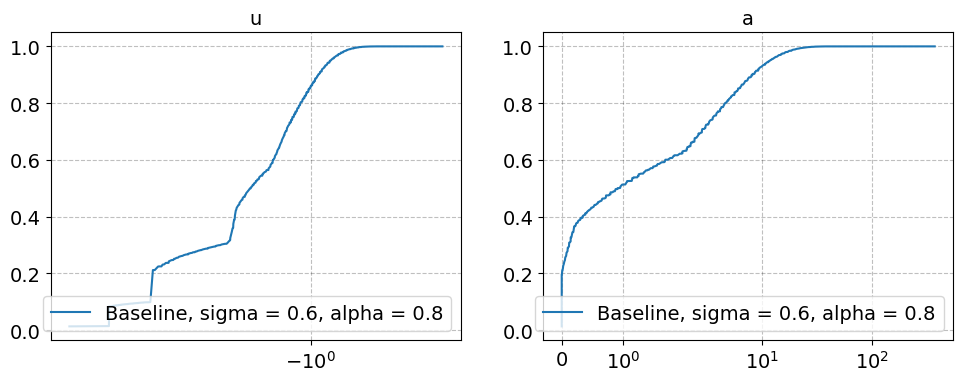

In [6]:
model_alt = HANCModelClass(name = f'Alternative, sigma = {sigma_alt}, alpha = {alpha_alt}')
model_alt.par.sigma = sigma_alt
model_alt.par.alpha = alpha_alt

# Initial values
model_alt.ss.r = 0.02*(1-0.1)
model_alt.ss.wt = 1.00*(1-0.3)
model_alt.ss.G = 0.2

model_alt.find_ss()
func.plot_cum([model_base], ['u', 'a'])

## 2. Marginal utility of consumption over G 

In [7]:
# MU - correct 

def MU(c, G, alpha, sigma, rho= 2.0):


    if sigma != 1.0:
                
        MU_c = alpha**(1/sigma)*c**(-1/sigma)   *            (alpha**(1/sigma)*c**((sigma-1)/sigma) + (1-alpha)**(1/sigma)*G**((sigma-1)/sigma))**((1-sigma*rho)/(sigma-1))
        

    else:

        MU_c = alpha * (1/ (alpha**alpha * (1-alpha)**(1-alpha))) **(1-rho) * c**(alpha*(1-rho) - 1) * G**((1-alpha)*(1-rho))

 

    return MU_c


# T

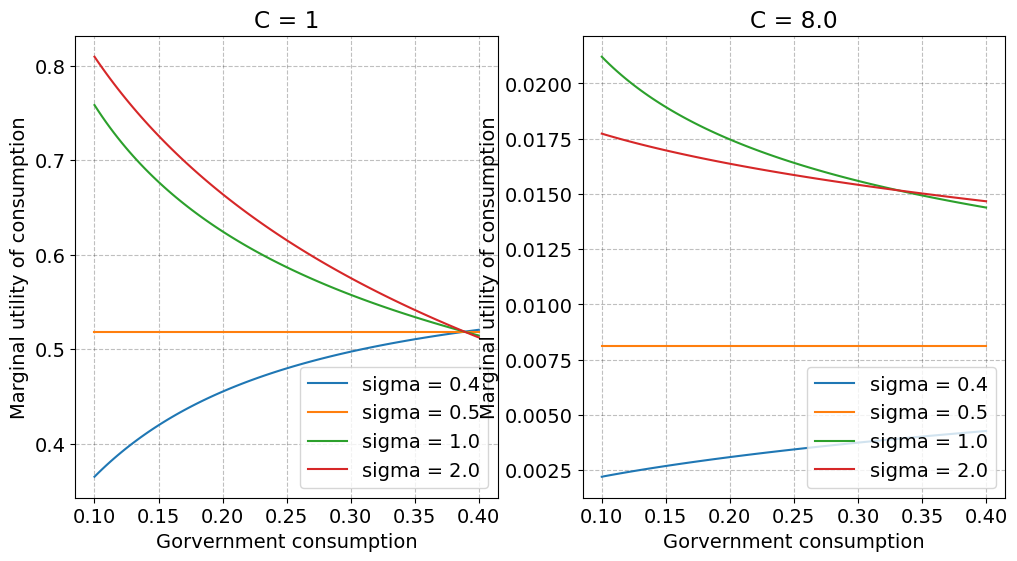

In [14]:

def plot_MUofC(c, c2, alpha_list, sigma_list, title = ''):

    # how does MU_C change with c for different values of G
    g = np.linspace(0.1, 0.4, 100)


    fig = plt.figure(figsize=(12, 6))


    ax1 = fig.add_subplot(121)

    for sigma in sigma_list:
        for alpha in alpha_list:
            # MU_list = MU_c(c, g, alpha, sigma)
            MU_list = MU(c, g, alpha, sigma, rho= 2.0)
            
            ax1.plot(g, MU_list, label=f'sigma = {sigma}')



    ax1.legend(loc='lower right')
    ax1.set_xlabel('Gorvernment consumption')
    ax1.set_ylabel('Marginal utility of consumption')
    ax1.set_title( title + f'C = {c}')


    ax1 = fig.add_subplot(122)

    for sigma in sigma_list:
        for alpha in alpha_list:
            MU_list = MU(c2, g, alpha, sigma, rho= 2.0)
            ax1.plot(g, MU_list, label=f'sigma = {sigma}')


    ax1.legend(loc='lower right')
    ax1.set_xlabel('Gorvernment consumption')
    ax1.set_ylabel('Marginal utility of consumption')
    ax1.set_title( f'C = {c2}')

plot_MUofC(c = 1, c2 = 8.0, alpha_list = [ 0.72], sigma_list=[ 0.4, 0.5, 1.0, 2.0])

# Saving 
plt.savefig(path + 'MuC_dS.png', bbox_inches='tight')





## 3. HH reactions to changes in w, G, r 

In [9]:
model_base.par.sigma = 1.0
model_base.solve_hh_ss()
model_base.simulate_hh_ss()

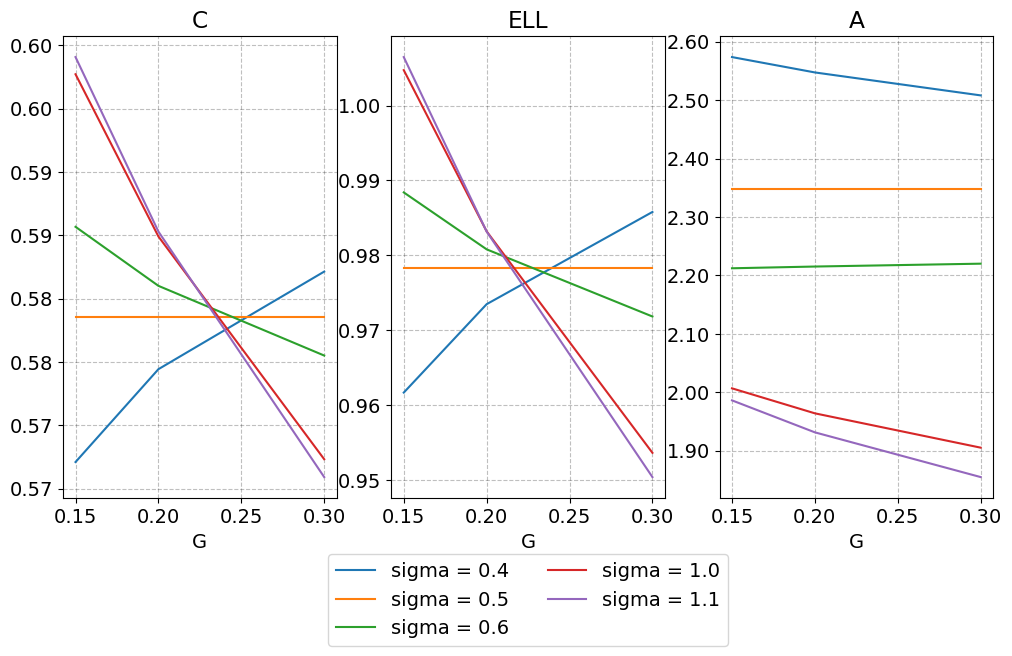

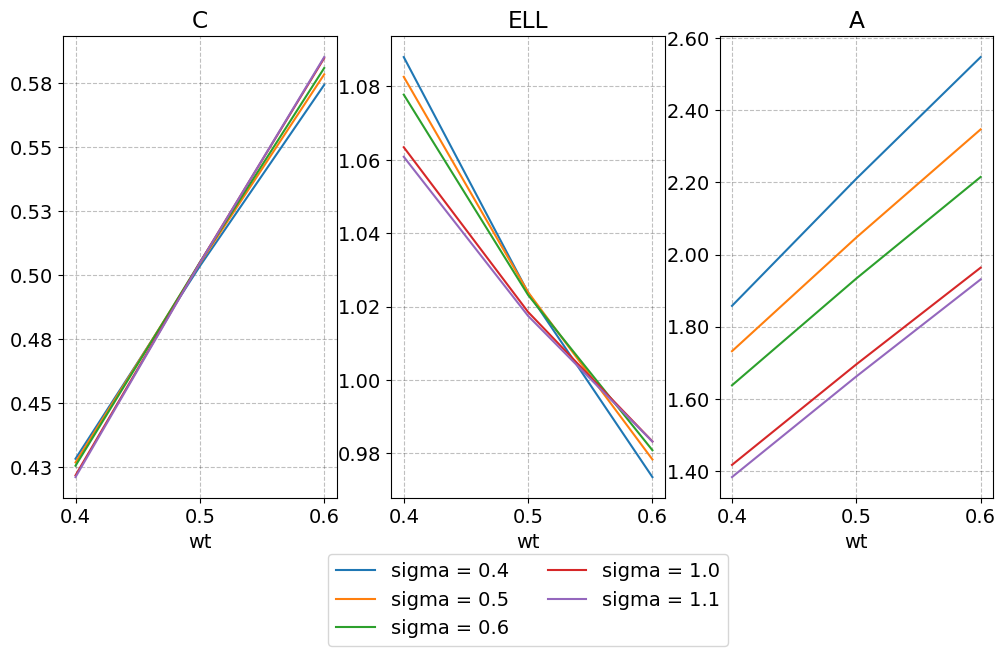

In [12]:

def lists_hh_reactions_w(model, list_wt = None, list_r = None, list_G = None):

    list_C = []
    list_ELL = []
    list_A = []
    list_U_hh = []


    # Set default values if lists are None
    if list_wt is None:
        list_wt = [model.ss.wt] #[0.7]
    if list_r is None:
        list_r = [model.ss.r] #[0.01]
    if list_G is None:
        list_G = [0.2]

    # Iterate over all combinations of wt, r, and G
    for wt in list_wt:
        model.ss.wt = wt
        for r in list_r:
            model.ss.r = r
            for G in list_G:
                model.ss.G = G


                try:
                    model.solve_hh_ss()
                    model.simulate_hh_ss()
                    list_C.append(model.ss.C_hh)
                    list_ELL.append(model.ss.ELL_hh)
                    list_A.append(model.ss.A_hh)
                    list_U_hh.append(model.ss.U_hh)

                except:
                    list_C.append(np.nan)
                    list_ELL.append(np.nan)
                    list_A.append(np.nan)
                    list_U_hh.append(np.nan)
                    print('Error at wt = ', wt)



    return list_C, list_ELL, list_A,  list_U_hh




def plot_hh_react(model, sigma_list, alpha_list , list_wt = None, list_r = None, list_G = None):

    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)


    if list_wt != None:
        list_ = list_wt
        ax1.set_xlabel('wt')
        ax2.set_xlabel('wt')
        ax3.set_xlabel('wt')

    if list_r != None:
        list_ = list_r
        ax1.set_xlabel('r')
        ax2.set_xlabel('r')
        ax3.set_xlabel('r')
    
    if list_G != None:
        list_ = list_G
        ax1.set_xlabel('G')
        ax2.set_xlabel('G')
        ax3.set_xlabel('G')
    # for model in [model]:

    for sigma in sigma_list:
        for alpha in alpha_list:
            model.par.sigma = sigma
            model.par.alpha = alpha

            list_C, list_ELL, list_A, list_U_hh = lists_hh_reactions_w(model, list_wt = list_wt, list_r = list_r, list_G = list_G)

            ax1.plot(list_, list_C, label=f'sigma = {sigma} ')#, alpha = {alpha}')
            ax2.plot(list_, list_ELL, label=f'sigma = {sigma}')#, alpha = {alpha}')
            ax3.plot(list_, list_A, label=f'sigma = {sigma}')#, alpha = {alpha}')
            # ax3.plot(list_, list_U_hh, label=f'sigma = {sigma}, alpha = {alpha}')

    ax1.set_title('C')
    ax2.set_title('ELL')
    ax3.set_title('A')
    # ax3.set_title('U_hh')


    # Adjusting ticks to keep 2 decimals only
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2f}".format(x)))
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2f}".format(x)))
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2f}".format(x)))

    # Legend below the plots
    
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  ncol=2)
    
# plot_hh_react(model_base,  alpha_list = [ 0.75], sigma_list=[0.5, 0.9,  1.1, 1.5], list_wt = [0.9, 1.0])


plot_hh_react(model_base,  alpha_list = [ 0.72], sigma_list=[0.4, 0.5, 0.6, 1.0, 1.1], list_G = [0.15, 0.2, 0.3])
plt.savefig(path + 'hh_react_G.png', dpi = 300, bbox_inches='tight')


plot_hh_react(model_base,  alpha_list = [ 0.72], sigma_list=[0.4, 0.5, 0.6, 1.0, 1.1], list_wt = [0.4, 0.5, 0.6])
plt.savefig(path + 'hh_react_wt.png', dpi = 300, bbox_inches='tight')


